In [64]:
from pathlib import Path 
import pylidc as pl
import numpy as np 
import os
import pandas as pd 
from tqdm import tqdm
from glob import glob
from multiprocessing import Pool, Manager
from pylidc.utils import consensus
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
LABELS = ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation',
          'texture', 'malignancy']

In [3]:
def scan2labels(scan_id):
    scan = pl.query(pl.Scan).filter(pl.Scan.id == scan_id).first()
    
    # Read nifti (required for correct affine matrix)
    scan_ann = []

    for nod_idx, nodules in enumerate(scan.cluster_annotations()): # Each scan has multiple nodules
        for ann_idx, ann in enumerate(nodules): # Each nodule was rated between 1 and 4 raters
            ann_dict = {label:getattr(ann, label) for label in LABELS}
            ann_dict['bbox'] = [[d.start, d.stop] for d in  ann.bbox()]
            ann_dict['scan_id'] = scan.id # equal for all nodules/annotations 
            ann_dict['nodule_idx'] = nod_idx 
            ann_dict['annotation_idx'] = ann_idx 
            ann_dict['annotation_num'] = len(nodules) 
            ann_dict['annotation_id'] = ann.id # unique - same annotator has different numbers 
            ann_dict['patient_id'] = scan.patient_id
            ann_dict['study_instance_uid'] = scan.study_instance_uid
            ann_dict['series_instance_uid'] = scan.series_instance_uid
            scan_ann.append(ann_dict)
    return scan_ann

In [4]:
scan_ids = range(1, len(list(pl.query(pl.Scan)))+1)

all_ann = []
for scan_id in tqdm(scan_ids):
    all_ann.extend(scan2labels(scan_id))

  6%|▋         | 66/1018 [00:14<04:21,  3.64it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 10%|▉         | 101/1018 [00:22<02:58,  5.15it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 14%|█▍        | 140/1018 [00:31<04:32,  3.22it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 20%|██        | 205/1018 [00:45<02:11,  6.17it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 25%|██▍       | 254/1018 [00:52<01:24,  9.07it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|███▎      | 335/1018 [01:02<01:17,  8.80it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 34%|███▎      | 342/1018 [01:05<03:46,  2.98it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 36%|███▋      | 370/1018 [01:09<01:15,  8.55it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 40%|████      | 408/1018 [01:18<04:33,  2.23it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 60%|██████    | 613/1018 [01:57<02:06,  3.21it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 70%|███████   | 714/1018 [02:15<00:54,  5.58it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|███████▊  | 790/1018 [02:28<00:59,  3.80it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|███████▊  | 794/1018 [02:29<00:37,  5.98it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 83%|████████▎ | 841/1018 [02:40<00:32,  5.46it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


100%|██████████| 1018/1018 [03:17<00:00,  5.15it/s]


In [ ]:
df = pd.DataFrame(all_ann)
unique_cols = ['patient_id', 'study_instance_uid', 'series_instance_uid', 'scan_id', 'nodule_idx']
df1 = df.groupby(unique_cols)['malignancy'].apply(lambda x:int(x.mean().round())).reset_index()

df2 = df.drop_duplicates(unique_cols)
df2 = df2.drop(columns='malignancy')

df = pd.merge(df1, df2, on=unique_cols).reset_index(drop=True)

# df = df[df['malignancy']!=3] # Remove all uncertain cases # See different approaches eg. https://doi.org/10.1038%2Fs41598-018-27569-w
df['Malignant'] = (df['malignancy'] > 3).astype(int) # 1: Malignant, 0: Benign
df['Calcification'] = (df['calcification'].isin([3,4,5])).astype(int) # 1: Atypical, 0: Benign
df['Sphericity'] = (df['sphericity'] > 3).astype(int) # 1: Spherical, 0: Non-spherical
df['Margin'] = (df['margin'] < 3).astype(int) # 1: Poorly defined, 0: Well defined
df['Lobulation'] = (df['lobulation'] > 3).astype(int) # 1: Lobulated, 0: Non-lobulated
df['Spiculation'] = (df['spiculation'] > 3).astype(int) # 1: Spiculated, 0: Non-spiculated
df['Texture'] = (df['texture'] >= 3).astype(int) # 1: Solid or part-solid, 0: Non-solid
df['InternalStructure'] = (df['internalStructure'] < 2).astype(int) # 1: soft tissue, 0: Non-soft tissue

df = df.reset_index(drop=True)
print("Number Annotations: ", len(df))
print("Number Nodules (>3mm)", len(np.unique(df[['scan_id', 'nodule_idx']])) )
print("Number Series: ", len(np.unique(df[ 'series_instance_uid'])))
print("Number Patients: ", len(np.unique(df[ 'patient_id'])))
len(df)

Malignant:  Malignant
0    2149
1     502
Name: count, dtype: int64
Calcification:  Calcification
0    2349
1     302
Name: count, dtype: int64
InternalStructure:  InternalStructure
1    2636
0      15
Name: count, dtype: int64
Sphericity:  Sphericity
1    1538
0    1113
Name: count, dtype: int64
Margin:  Margin
0    2237
1     414
Name: count, dtype: int64
Lobulation:  Lobulation
0    2480
1     171
Name: count, dtype: int64
Spiculation:  Spiculation
0    2478
1     173
Name: count, dtype: int64
Texture:  Texture
1    2382
0     269
Name: count, dtype: int64
InternalStructure:  InternalStructure
1    2636
0      15
Name: count, dtype: int64
Number Annotations:  2651
Number Nodules (>3mm) 884
Number Series:  883
Number Patients:  875


2651

In [57]:
series = glob('/mnt/nas/CT/LIDC-IDRI/*')
series = [os.path.basename(s) for s in series]
len(list(set(series)))
df = df[df['series_instance_uid'].isin(series)]

labels = [
    'Malignant', 
    'Calcification', 
    'Sphericity', 
    'Margin', 
    'Lobulation', 
    'Spiculation', 
    'Texture', 
    # 'InternalStructure'
]

result = []

for s in series:
    # Subset the DataFrame for this series
    df_s = df[df['series_instance_uid'] == s]
    if len(df_s) > 0:
        # Prepare the dictionary for this series
        row = {'series_instance_uid': s}
        
        if df_s.empty:
            # If no nodules for this series, default everything to 0
            for lab in labels:
                row[lab] = 0
        else:
            # For each label, set to 1 if any nodule in df_s has that label = 1
            for lab in labels:
                row[lab] = int(df_s[lab].eq(1).any())
        
        # Append result
        result.append(row)

df_new = pd.DataFrame(result).drop_duplicates()
df_new['Malignant'].value_counts()
df_meta = pd.read_csv('/mnt/nas/CT/label_files/LIDC/LIDC-IDRI_MetaData.csv').sort_values('Subject ID')
ps_dict = dict(zip(df_meta['Series ID'], df_meta['Subject ID']))
p_list = []
for s in df_new['series_instance_uid']:
    p_list.append(ps_dict[s])
df_new['patient_id'] = p_list
df_new['VolumeName'] = df_new['series_instance_uid'] + '.nii.gz'
len(df_new)

df_new.head()
# print(len(np.intersect1d(series, df['series_instance_uid'].tolist())))

1018

Malignant
0    524
1    359
Name: count, dtype: int64

883

,series_instance_uid,Malignant,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,patient_id,VolumeName
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.280125803152...,0,0,1,1,0,0,1,LIDC-IDRI-0042,1.3.6.1.4.1.14519.5.2.1.6279.6001.280125803152...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157...,1,0,1,1,0,0,1,LIDC-IDRI-0048,1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233...,1,1,1,0,0,1,1,LIDC-IDRI-0087,1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.311102747717...,0,0,1,0,0,0,1,LIDC-IDRI-0110,1.3.6.1.4.1.14519.5.2.1.6279.6001.311102747717...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634...,0,0,1,0,0,0,1,LIDC-IDRI-0227,1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634...


In [58]:
train_list, test_list = train_test_split(df_new['patient_id'].unique().tolist(), test_size=0.3, random_state=42)
df_test = df_new[df_new['patient_id'].isin(test_list)]
test_list, val_list = train_test_split(df_test['patient_id'].unique().tolist(), test_size=50, random_state=42)
len(train_list), len(val_list), len(test_list)
# len(np.intersect1d(train_list, val_list)), len(np.intersect1d(train_list, test_list)), len(np.intersect1d(val_list, test_list))

(612, 50, 213)

In [62]:
df_train = df_new[df_new['patient_id'].isin(train_list)]
df_val = df_new[df_new['patient_id'].isin(val_list)]
df_test = df_new[df_new['patient_id'].isin(test_list)]

for label in labels:
    df_train[label].value_counts(), df_val[label].value_counts(), df_test[label].value_counts()

(Malignant
 0    378
 1    239
 Name: count, dtype: int64,
 Malignant
 0    27
 1    23
 Name: count, dtype: int64,
 Malignant
 0    119
 1     97
 Name: count, dtype: int64)

(Calcification
 0    473
 1    144
 Name: count, dtype: int64,
 Calcification
 0    40
 1    10
 Name: count, dtype: int64,
 Calcification
 0    171
 1     45
 Name: count, dtype: int64)

(Sphericity
 1    476
 0    141
 Name: count, dtype: int64,
 Sphericity
 1    36
 0    14
 Name: count, dtype: int64,
 Sphericity
 1    165
 0     51
 Name: count, dtype: int64)

(Margin
 0    453
 1    164
 Name: count, dtype: int64,
 Margin
 0    29
 1    21
 Name: count, dtype: int64,
 Margin
 0    154
 1     62
 Name: count, dtype: int64)

(Lobulation
 0    532
 1     85
 Name: count, dtype: int64,
 Lobulation
 0    45
 1     5
 Name: count, dtype: int64,
 Lobulation
 0    180
 1     36
 Name: count, dtype: int64)

(Spiculation
 0    536
 1     81
 Name: count, dtype: int64,
 Spiculation
 0    45
 1     5
 Name: count, dtype: int64,
 Spiculation
 0    176
 1     40
 Name: count, dtype: int64)

(Texture
 1    594
 0     23
 Name: count, dtype: int64,
 Texture
 1    49
 0     1
 Name: count, dtype: int64,
 Texture
 1    208
 0      8
 Name: count, dtype: int64)

In [60]:
df_train.to_csv('../csvs/LIDC_train.csv', index=False)
df_val.to_csv('../csvs/LIDC_validation_set.csv', index=False)
df_test.to_csv('../csvs/LIDC_test_set.csv', index=False)

(384, 512, 512)

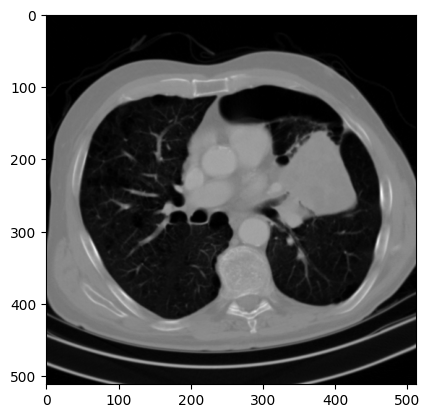

In [74]:
niis = glob('/mnt/nas/CT/npz_npy_LIDC/*.npz')
nii = np.random.choice(niis)
nii = np.load(nii)
nii['img_data'].shape
_ = plt.imshow(nii['img_data'][240], cmap='gray')